# Agent-based model for News diffusion and misinformation

What I want to do is to create agents that share news, then from there find some interesting insights that could help fake news research    
Test 1 Does having fake news affect real news sharing?    
Test 2 Does a news source matter in the design?    
Test 3 Does a news event matter in the design?    
Test 4 Do people just share what they are told (Illusory of truth)?    
Test 5 How people could be silenced?    
Test 6 Does fake news shift the public opinion?

#### The first thing we need to do is to import news article and user classes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from SimHelper import generate_weighted_sentiment
from random import sample, randint
from tqdm import tqdm_notebook as tqdm
from classes import NewsArticle,User, NewsAgency
import pylab

1. User attributes:  
  a. unique_id : a non-intelligent number given to the user  
  b. news_spread_chance : a percentage of the user spreading news (can be compared to confidence and censorship)   
  c. preference : the position the user feels about the current subject being discussed  
  d. user_type: the user could be a regular user or a news agency  
  e. articles : a list of articles shared by the user  



2. News agency attributes:  
  a. unique_id : a non-intelligent number given to the user  
  b. news_spread_chance : a percentage of the user spreading news (can be compared to confidence and censorship)   
  c. preference : the position the user feels about the current subject being discussed  
  d. user_type: the user could be a regular user or a news agency  
  e. articles : a list of articles shared by the user  
  f. reliable : indicates how reliable this agency is
        
        
3. News article attributes:  
  a. news_article_id : a non-intelligenct number given to the article  
  b. source_id : the id of the source  
  c. source_preference : the preference of the source  
  d. sentiment : a number from [1,5] or [-5,-1]  
  e. num_shares :  the number of people sharing the article  
  f. fake : 1 if the news is fake, otherwise real

#### Lets try to create a simple news article

In [2]:
x = NewsArticle(1,100,0.8,0.7,4,21,1,50)

In [3]:
x

News Article ID: 1
Source ID: 100
Source Preference: 0.8
Article Preference: 0.7
Sentiment: 4
Number of shares: 21
Fake (True:1, False:0): 1
Tick: 50

In [4]:
u = User(1000,0.5,0.2,'regular',[x])

In [5]:
u

User ID: 1000
News Spread Chance: 0.5
Preference: 0.2
Type: regular

In [6]:
n = NewsAgency(8000,0.9,-0.8,'news_agency',[x],1)

In [7]:
n

User ID: 8000
News Spread Chance: 0.9
Preference: -0.8
Type: news_agency
Reliable:1

#### Now we need to try to create a few users

news_agencies_ratio is a network attribute to add that takes the amount of news agencies in the network  
number_of_users is a network attribute that creates a graph of a certain number of nodes equal to the number of users

In [8]:
from random import random, uniform, choice
from SimHelper import generate_weighted_percentage, generate_bias
from scipy.stats import beta

In [9]:
users = []
regular_users = []
news_users = []

news_agencies_ratio = 0.1
number_of_users = 60

number_of_regualr_users = int(number_of_users*(1-news_agencies_ratio))
number_of_news_users = number_of_users - number_of_regualr_users

print('Number of users:',number_of_users,'\nNumber of regular users:',number_of_regualr_users,'\nNumber of news agencies:',number_of_news_users)

Number of users: 60 
Number of regular users: 54 
Number of news agencies: 6


In [10]:
#create the beta distribution for news agencies to be a beta distribution with alpha=beta=0.3
data_beta = beta.rvs(a=0.3,b=0.3,size=1000)
# data_beta = beta.rvs(a=1,b=5,size=1000)
beta_dist = np.interp(data_beta, (data_beta.min(), data_beta.max()), (-1, 1))
news_reliability = 1


for i in tqdm(range(number_of_news_users)):
    unique_id = i
    user_type = 'news_agency' 
    news_spread_chance = 1
    articles = []
    reliable = (generate_weighted_percentage(news_reliability))
    if reliable == 0:
        preference = round(choice([x for x in beta_dist if abs(x)>0.4]),2)
    else:
        preference = round(choice([x for x in beta_dist if abs(x)<0.5]),2)
    news_users.append(NewsAgency(unique_id,news_spread_chance,preference,user_type,articles,reliable))
    users.append(NewsAgency(unique_id,news_spread_chance,preference,user_type,articles,reliable))

for i in tqdm(range(len(news_users),number_of_regualr_users+len(news_users))):
    unique_id = i
    user_type = 'regular'
    news_spread_chance = round(random(),2)
    preference = generate_bias(mu = 0, sigma = 3)    
    articles = []
    regular_users.append(User(unique_id,news_spread_chance,preference,user_type,articles))
    users.append(User(unique_id,news_spread_chance,preference,user_type,articles))
print('Number of users:',number_of_users)
print('Number of regular users:',number_of_regualr_users)
print('Number of news agencies:',number_of_news_users)


Number of users: 60
Number of regular users: 54
Number of news agencies: 6


In [11]:
users[21]

User ID: 21
News Spread Chance: 0.68
Preference: 0.25
Type: regular

In [12]:
regular_user_count = len([user for user in users if user.user_type == 'regular'])
print('Ratio of regular users=',regular_user_count/number_of_users,' ,and new agencies =', (number_of_users-regular_user_count)/number_of_users)

Ratio of regular users= 0.9  ,and new agencies = 0.1


### Lets try to create a network of the users

In [13]:
import networkx as nx

In [14]:
G = nx.Graph()
color_map = []
for u in users:    
    if isinstance(u,NewsAgency):
        G.add_node(u.unique_id,s="^", news_spread_chance = u.news_spread_chance, 
                   preference = u.preference, reliable= u.reliable, articles = u.articles, user_type = u.user_type )
    else:
        G.add_node(u.unique_id,s="o", news_spread_chance = u.news_spread_chance, 
                   preference = u.preference, articles = u.articles, user_type = u.user_type )
    if u.preference < -0.2:
        color_map.append('red')
    elif u.preference > 0.2:
        color_map.append('blue')
    else:
        color_map.append('grey') 

(array([ 1.,  2.,  8.,  9.,  8., 11.,  9.,  7.,  1.,  4.]),
 array([-0.76 , -0.615, -0.47 , -0.325, -0.18 , -0.035,  0.11 ,  0.255,
         0.4  ,  0.545,  0.69 ]),
 <a list of 10 Patch objects>)

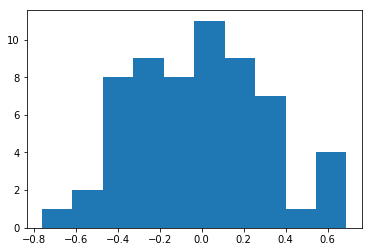

In [16]:
p = []
for node in list(G.nodes()):
    p.append(G.nodes[node]['preference'])
plt.hist(p)

#### Add edges by Power law distribution

In [17]:
edge_list = []
for i in range(number_of_users):
    number_of_edges = int((np.random.pareto(a=5)+.1)*30)
    if number_of_edges > number_of_users:
        number_of_edges /= 2
    edge_list.append(int(number_of_edges))

(array([29., 12.,  6.,  2.,  4.,  2.,  2.,  0.,  1.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 3.  ,  5.85,  8.7 , 11.55, 14.4 , 17.25, 20.1 , 22.95, 25.8 ,
        28.65, 31.5 , 34.35, 37.2 , 40.05, 42.9 , 45.75, 48.6 , 51.45,
        54.3 , 57.15, 60.  ]),
 <a list of 20 Patch objects>)

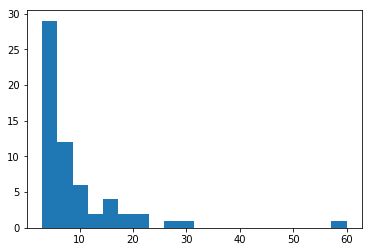

In [18]:
plt.hist(edge_list,bins=20)

In [19]:
def get_similarity(x,y):
    return round(1 - abs(G.nodes[x]['preference'] - G.nodes[y]['preference'])/2,2)

In [20]:
from random import sample
for i in range(number_of_users):
    neighbors = sample(users,edge_list[i])
#     print(neighbors)
    for neighbor in neighbors:
        u = users[i].unique_id
        v = neighbor.unique_id
        s = get_similarity(u,v)
        G.add_edge(u,v,weight=s)  

C:\Users\abdal\AppData\Local\conda\conda\envs\simulations\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


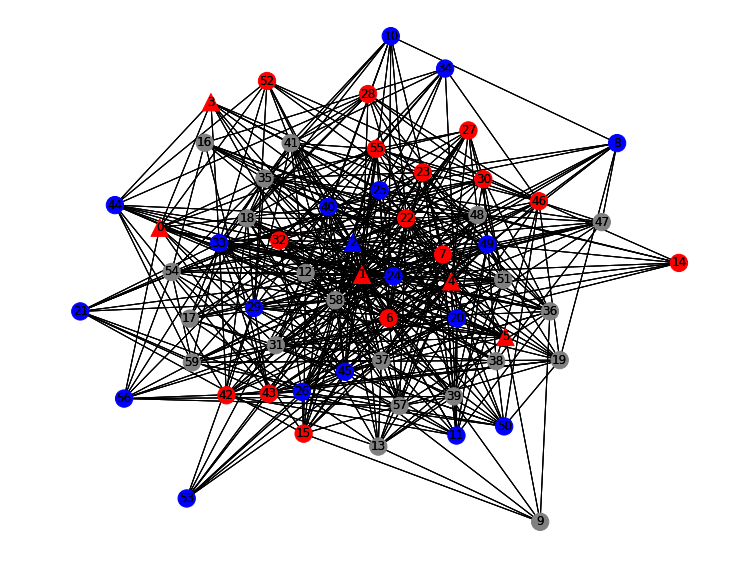

In [21]:
#Drawing the graph
#First obtain the node positions using one of the layouts
nodePos = nx.layout.spring_layout(G)
plt.figure(1,figsize=(12,10))
#The rest of the code here attempts to automate the whole process by
#first determining how many different node classes (according to
#attribute 's') exist in the node set and then repeatedly calling 
#draw_networkx_node for each. Perhaps this part can be optimised further.

#Get all distinct node classes according to the node shape attribute
nodeShapes = set((aShape[1]["s"] for aShape in G.nodes(data = True)))

#For each node class...
for aShape in nodeShapes:
    #...filter and draw the subset of nodes with the same symbol in the positions that are now known through the use of the layout.
    filtered_list = [sNode[0] for sNode in filter(lambda x: x[1]["s"]==aShape,G.nodes(data = True))]
    if filtered_list[0] == 0:
        filtered_color = color_map[:len(filtered_list)]
    else:
        filtered_color = color_map[filtered_list[0]:]
#     nx.draw_networkx_nodes(G,nodePos,node_shape = aShape, nodelist = [sNode[0] for sNode in filter(lambda x: x[1]["s"]==aShape,G.nodes(data = True))])
    nx.draw_networkx(G,nodePos,node_shape = aShape, nodelist = filtered_list,node_color=filtered_color)
#     nx.draw_networkx(G,nodePos,node_shape = aShape,node_color=color_map)

#Finally, draw the edges between the nodes
nx.draw_networkx_edges(G,nodePos)
plt.axis("off")
#And show the final result
pylab.show()

In [22]:
import collections

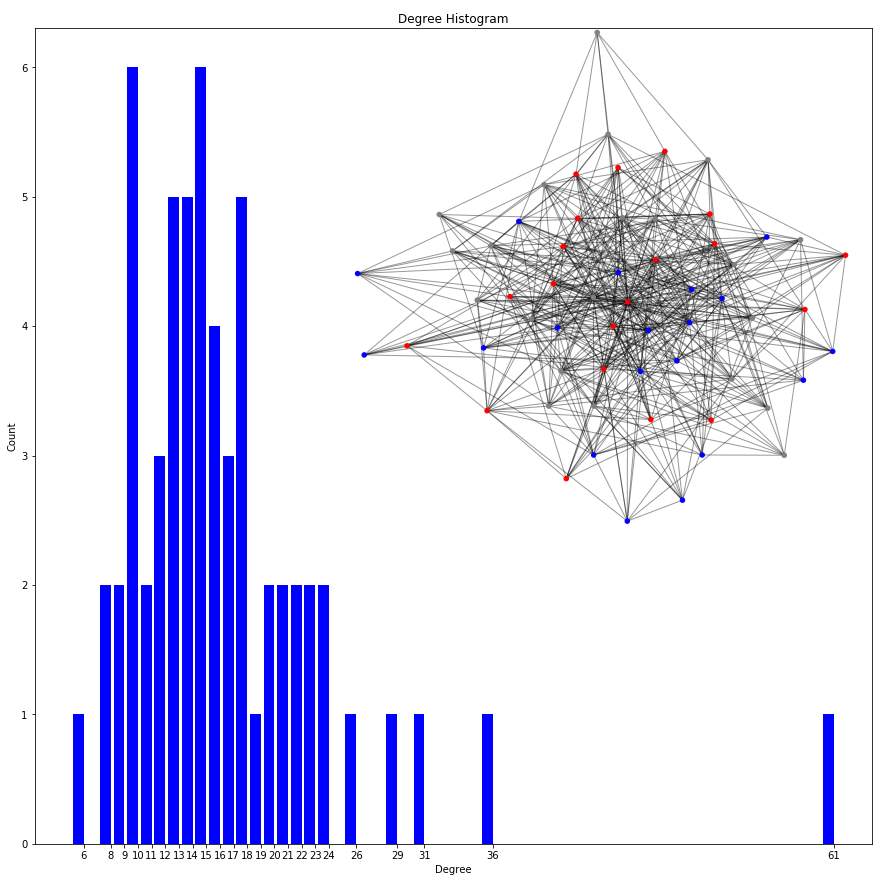

In [23]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots(figsize=(15,15))
plt.bar(deg, cnt, width=0.80, color="b")
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(G)
plt.axis("off")
nx.draw_networkx_nodes(G, pos, node_size=20, node_color=color_map)
nx.draw_networkx_edges(G, pos, alpha=0.4)
plt.show()

#### Lets spread some news and see how users change their preferences

ticks is another network variable that is used to measure time, it does not mean a specfic time stamp we know at the moment  
fake_news_prob is another network variable that measures how much the percentage of fake news will be generated throughout the network  
For every time step t:  
- Make news events from the news agencies  
- Ask every agent to spread their articles across the network  
- Change the 'regular' user preference and compute overall network preference

In [24]:
def create_news_event (user,sentiment,fake,tick):
    """
    Make a news event
    a. news_article_id
    b. source_id : the id of the source
    c. source_preference : the preference of the source
    d. sentiment : a number from [1,5] or [-5,-1]
    e. num_shares : the number of people sharing the article
    f. fake : 1 if the news is fake, otherwise real
    """
    # assign an id in the format of user id + 1000
    if not user.articles:
        news_id = int(str(user.unique_id)+str(1000))
    else:
        news_id = user.articles[-1].news_article_id +1
#     print(news_id)
    # get source_id and source_preference
    source_id = user.unique_id
    source_preference = user.preference
    #generate a preference randomly distributed around the source preference
    if fake:
        article_preference = round(np.random.normal(loc=source_preference, scale = 0.14),2)
        if np.sign(article_preference) != np.sign(user.preference):
            article_preference *= -1
    else:
        article_preference = round(np.random.normal(loc=source_preference, scale = 0.07),2)
    if article_preference > 1:
        article_preference = 1
    elif article_preference < -1:
        article_preference = -1
    sentiment = sentiment
    num_shares = 1
    fake = fake
    tick = tick
    
    article = NewsArticle(news_id,source_id,source_preference,article_preference,sentiment,num_shares,fake,tick)
    
    user.articles.append(article)

Test the create_news_event function

In [27]:
u = User(1000,0.5,0.2,'regular',[x])
if u.articles:
    u.articles.clear()
create_news_event(u,generate_weighted_sentiment(),0,3)

u.articles[0]

News Article ID: 10001000
Source ID: 1000
Source Preference: 0.2
Article Preference: 0.14
Sentiment: -2.83
Number of shares: 1
Fake (True:1, False:0): 0
Tick: 3

In [58]:
def get_neighbor_preferences(user):
    """
    Get the average preference of a user's neighbors
    """
    return round(np.mean([G.nodes[n]['preference'] for n in list(G[user.unique_id])]),2)
#     return round(np.mean([o.preference for o in list(G[users[user.unique_id]])]),2)

    # Simpler version
#     temp = []
#     for n in list(G[users[user.unique_id]]):
#         print(abs(user.preference - n.preference))
#         temp.append(n.preference)
#     return round(np.mean(temp),2)

Test get_neighbor_preferences

In [59]:
get_neighbor_preferences(users[0])

-0.06

### DIGRESSION

In [57]:
# u1= User(1000,0.5,0.2,'regular',[])
# u2= User(1001,0.7,-0.2,'regular',[])
# u3= User(1002,0.1,-0.6,'regular',[])
# u4= User(1003,0.5,0.7,'regular',[])
# u5= User(1004,0.3,0.3,'regular',[])

# H = nx.Graph()
# H.add_nodes_from([u1,u2,u3,u4,u5])

# H.add_edge(u1,u4)
# H.add_edge(u4,u5)
# H.add_edge(u5,u2)
# H.add_edge(u2,u3)
# H.add_edge(u3,u1)
# H.add_edge(u1,u5)

# plt.figure(1,figsize=(23,12))
# nx.draw_networkx(H)
# plt.axis('off')
# plt.show()

# round(np.mean([o.preference for o in list(H[u5])]),2)

# create_news_event(u1,generate_weighted_sentiment(),0,0)
# create_news_event(u1,generate_weighted_sentiment(a=4),1,0)
# create_news_event(u1,generate_weighted_sentiment(),0,1)
# create_news_event(u2,generate_weighted_sentiment(),0,2)
# create_news_event(u4,generate_weighted_sentiment(a=4),0,2)

# recommendations = [article for user in list(H[u5]) for article in user.articles if np.sign(u5.preference) == np.sign(article.article_preference)]
# recommendations.sort(key=lambda x: (abs(x.sentiment),x.tick,x.num_shares), reverse=True)

# recommendations

# np.sign(u1.preference) == np.sign(recommendations[0].article_preference) == np.sign(u4.preference)

# preds = nx.preferential_attachment(H)
# # for u, v, p in preds:
# #     print('(%d, %d) -> %d' % (u, v, p))

# list(preds)

# from networkx.algorithms.community.kernighan_lin import kernighan_lin_bisection as klb
# from networkx.algorithms.community.centrality import girvan_newman as gn

# communities = klb(G)

# communities[1]

# comp = gn(G)

# tuple(sorted(c) for c in next(comp))

In [72]:
def get_recommendations(user,tick):
    """
    Pick what the user will see on their feed according to a platform strategy
    
    Strategy 1: See the latest news from your neighbors
    Strategy 2: See the most popular news
    Strategy 3: See the most important news in your circle
    Strategy 4: See a random selected news as a benchmark
    Strategy 5: Weighted approach
    Strategy 6: Most shocking news
    """
    recommendations = [article for neighbor in list(G[user.unique_id]) for article in G.nodes[neighbor]['articles'] if article.tick > tick -5]
    recommendations = [article for article in recommendations if np.sign(user.preference) == np.sign(article.article_preference)]
    recommendations.sort(key=lambda x: (x.tick,abs(x.sentiment)), reverse=True)
    try:
        return recommendations[:3]
    except:
        return recommendations

In [198]:
def spread_news(user,tick):
    """
    A user will share to their neighbors based on preference, sentiment, and number of shares
    
    In terms of preference, there are a few measures to find:
    1- individual preferences: user preference and neighbor preference
    2- community preference : mean of preference of neighbors of the neighbor
    3- 
    """
#     if not user.articles:
#         return
    
    community_opinion = get_neighbor_preferences(user)
    recommendations = get_recommendations(user,tick)
    
    for rec in recommendations:
        # person likes to share
        if generate_weighted_percentage(user.news_spread_chance):
            #person is not silenced
            if np.sign(community_opinion) == np.sign(user.preference) == np.sign(rec.article_preference):
                if rec not in user.articles and user.user_type =='regular':
                    user.articles.append(rec)
                    rec.num_shares += 1
                    preference_shift = 0.03
#                     print(user.unique_id,'before update:',users[user.unique_id].preference)
                    users[user.unique_id].preference = round(users[user.unique_id].preference,2)
                    if (np.sign(user.preference) > 0):
                        if users[user.unique_id].preference > rec.article_preference:
                            users[user.unique_id].preference -= preference_shift
#                             print(user.unique_id,'after update:',users[user.unique_id].preference)
                        elif users[user.unique_id].preference < rec.article_preference:
                            users[user.unique_id].preference += preference_shift
#                             print(user.unique_id,'after update:',users[user.unique_id].preference)
                    elif (np.sign(user.preference) < 0):
                        if users[user.unique_id].preference > rec.article_preference:
                            users[user.unique_id].preference -= preference_shift
#                             print(user.unique_id,'after update:',users[user.unique_id].preference)
                        elif users[user.unique_id].preference < rec.article_preference:
                            users[user.unique_id].preference += preference_shift
#                             print(user.unique_id,'after update:',users[user.unique_id].preference)
                    if users[user.unique_id].preference > 1:
                        users[user.unique_id].preference = 1
                    elif users[user.unique_id].preference < -1:
                        users[user.unique_id].preference = -1

In [188]:
def get_regular_user_preferences():
    """
    return the mean and std dev of the user preference
    """
#     preferences = []
#     for node in regular_users:
#         preferences.append(node.preference)

    preferences = []
    for node in users:
        preferences.append(node.preference)

    print('mean = ',round(np.mean(preferences),2),'standard dev = ',round(np.std(preferences),2))
    plt.hist(preferences)

mean =  -0.07 standard dev =  0.35


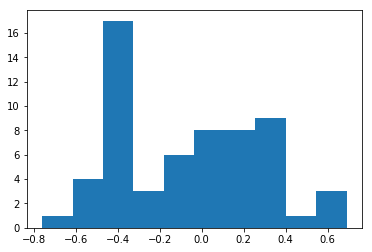

In [189]:
get_regular_user_preferences()

(array([4., 8., 6., 6., 4., 5., 8., 4., 6., 3.]),
 array([0.01 , 0.109, 0.208, 0.307, 0.406, 0.505, 0.604, 0.703, 0.802,
        0.901, 1.   ]),
 <a list of 10 Patch objects>)

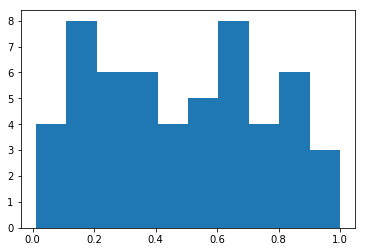

In [190]:
sharing = [x.news_spread_chance for x in users if x.user_type == 'regular']
plt.hist(sharing)

(array([ 1.,  4., 17.,  3.,  6.,  8.,  8.,  9.,  1.,  3.]),
 array([-0.76 , -0.615, -0.47 , -0.325, -0.18 , -0.035,  0.11 ,  0.255,
         0.4  ,  0.545,  0.69 ]),
 <a list of 10 Patch objects>)

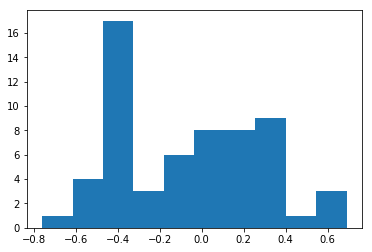

In [191]:
preferences = []
for node in users:
    preferences.append(node.preference)

plt.hist(preferences)

In [192]:
[u.unique_id for u in news_users]

[0, 1, 2, 3, 4, 5]

In [193]:
[u.preference for u in users if u.user_type == 'news_agency']

[-0.385, -0.36, 0.22, -0.445, -0.425, -0.46499999999999997]

In [194]:
users[0].preference 

-0.385

(array([4., 0., 1., 0., 0., 0., 0., 0., 0., 1.]),
 array([-0.43 , -0.365, -0.3  , -0.235, -0.17 , -0.105, -0.04 ,  0.025,
         0.09 ,  0.155,  0.22 ]),
 <a list of 10 Patch objects>)

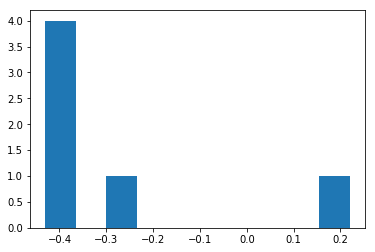

In [195]:
preferences = []
for node in news_users:
    preferences.append(node.preference)

plt.hist(preferences)

In [196]:
def clear_all_news():
    [user.articles.clear() for user in users]

In [197]:
ticks = 500
pause = 100
fake_news_prob = 0.0

clear_all_news()

fig,axs = plt.subplots(int(ticks/pause),figsize=(25,25))
fig.suptitle('Regular users preferences over time')
plots = 0
for tick in range(ticks):
    if tick % pause == 0:
        print('tick number: ',tick)
#         get_regular_user_preferences()
        preferences = [user.preference for user in users if user.user_type == 'regular']
        print('mean = ',round(np.mean(preferences),2),'standard dev = ',round(np.std(preferences),2))
        axs[plots].hist(preferences)
        plots += 1
        
    sampled_news_agencies = sample(news_users,randint(1,len(news_users)-1))
    for n in sampled_news_agencies:
        if n.reliable == 0:
            if generate_weighted_percentage(fake_news_prob):
                #generate fake news
                sentiment = generate_weighted_sentiment(a=4)
                fake = 1
        else:
            #generate real news
            sentiment = generate_weighted_sentiment()
            fake = 0
        create_news_event(n,sentiment,fake,tick)
        spread_news(n,tick)
    sampled_regular_users = sample(regular_users,randint(1,len(regular_users)-1))
    for u in sampled_regular_users:
        spread_news(u,tick)
print('mean = ',round(np.mean(preferences),2),'standard dev = ',round(np.std(preferences),2))

tick number:  0
mean =  -0.05 standard dev =  0.35
23 before update: -0.435
23 after update: -0.4
18 before update: -0.45499999999999996
18 after update: -0.42000000000000004
20 before update: 0.305
20 after update: 0.27
58 before update: -0.415
58 after update: -0.43999999999999995
58 before update: -0.43999999999999995
58 after update: -0.41000000000000003
58 before update: -0.41000000000000003
58 after update: -0.43999999999999995
9 before update: -0.45499999999999996
9 after update: -0.42000000000000004
26 before update: 0.285
26 after update: 0.25
28 before update: -0.53
28 after update: -0.5
30 before update: -0.415
30 after update: -0.43999999999999995
18 before update: -0.42000000000000004
18 after update: -0.44999999999999996
23 before update: -0.4
23 after update: -0.43000000000000005
14 before update: -0.515
14 after update: -0.49
9 before update: -0.42000000000000004
9 after update: -0.39
55 before update: -0.49
55 after update: -0.45999999999999996
16 before update: -0.415

16 after update: -0.41000000000000003
55 before update: -0.46
55 after update: -0.43000000000000005
27 before update: -0.37
46 before update: -0.39
46 after update: -0.36
20 before update: 0.24
23 before update: -0.4
23 after update: -0.37
23 before update: -0.37
23 before update: -0.37
23 after update: -0.33999999999999997
18 before update: -0.39
18 after update: -0.36
46 before update: -0.36
46 after update: -0.39
46 before update: -0.39
46 after update: -0.36
28 before update: -0.41000000000000003
28 after update: -0.38
28 before update: -0.38
28 after update: -0.41000000000000003
57 before update: -0.36
57 after update: -0.39
57 before update: -0.39
57 after update: -0.36
23 before update: -0.33999999999999997
23 after update: -0.37
23 before update: -0.37
23 after update: -0.4
18 before update: -0.36
18 after update: -0.39
58 before update: -0.35
58 after update: -0.38
14 before update: -0.37
14 after update: -0.4
16 before update: -0.41000000000000003
16 after update: -0.38
16 be

28 after update: -0.43999999999999995
16 before update: -0.41000000000000003
16 after update: -0.43999999999999995
23 before update: -0.33999999999999997
23 after update: -0.37
23 before update: -0.37
23 after update: -0.4
27 before update: -0.37
27 after update: -0.4
16 before update: -0.43999999999999995
16 after update: -0.47
58 before update: -0.47
58 after update: -0.43999999999999995
58 before update: -0.43999999999999995
58 after update: -0.41000000000000003
58 before update: -0.41000000000000003
28 before update: -0.43999999999999995
28 after update: -0.41000000000000003
30 before update: -0.41000000000000003
23 before update: -0.4
23 after update: -0.43000000000000005
23 before update: -0.43000000000000005
23 after update: -0.4
18 before update: -0.42000000000000004
18 after update: -0.44999999999999996
46 before update: -0.39
46 after update: -0.42000000000000004
9 before update: -0.44999999999999996
9 after update: -0.42000000000000004
9 before update: -0.42000000000000004
9

20 after update: 0.18
57 before update: -0.39
57 after update: -0.42000000000000004
23 before update: -0.45999999999999996
23 after update: -0.43000000000000005
18 before update: -0.39
18 after update: -0.36
18 before update: -0.36
18 after update: -0.39
9 before update: -0.44999999999999996
9 after update: -0.42000000000000004
16 before update: -0.5
16 after update: -0.47
16 before update: -0.47
16 after update: -0.5
46 before update: -0.48
46 after update: -0.44999999999999996
46 before update: -0.44999999999999996
46 after update: -0.42000000000000004
30 before update: -0.5
30 after update: -0.47
30 before update: -0.47
30 after update: -0.43999999999999995
58 before update: -0.41000000000000003
58 after update: -0.38
14 before update: -0.49
14 after update: -0.45999999999999996
58 before update: -0.38
58 after update: -0.41000000000000003
58 before update: -0.41000000000000003
58 after update: -0.43999999999999995
57 before update: -0.42000000000000004
57 after update: -0.39
46 bef

18 after update: -0.42000000000000004
18 before update: -0.42000000000000004
18 after update: -0.44999999999999996
16 before update: -0.43999999999999995
16 after update: -0.41000000000000003
28 before update: -0.38
28 after update: -0.41000000000000003
9 before update: -0.42000000000000004
9 after update: -0.39
9 before update: -0.39
9 after update: -0.42000000000000004
55 before update: -0.33999999999999997
55 after update: -0.31000000000000005
55 before update: -0.31000000000000005
55 after update: -0.33999999999999997
27 before update: -0.4
27 after update: -0.37
27 before update: -0.37
27 after update: -0.4
28 before update: -0.41000000000000003
28 after update: -0.43999999999999995
20 before update: 0.21
20 after update: 0.24
20 before update: 0.24
20 after update: 0.27
26 before update: 0.25
26 after update: 0.22
16 before update: -0.41000000000000003
16 after update: -0.43999999999999995
16 before update: -0.43999999999999995
16 after update: -0.41000000000000003
14 before upda

23 after update: -0.37
26 before update: 0.25
57 before update: -0.36
57 after update: -0.39
57 before update: -0.39
57 after update: -0.36
46 before update: -0.39
46 after update: -0.42000000000000004
23 before update: -0.37
23 after update: -0.4
55 before update: -0.4
55 after update: -0.43000000000000005
58 before update: -0.31999999999999995
58 after update: -0.35
58 before update: -0.35
58 after update: -0.38
16 before update: -0.38
16 after update: -0.41000000000000003
30 before update: -0.35
30 after update: -0.38
27 before update: -0.33999999999999997
27 after update: -0.37
28 before update: -0.41000000000000003
28 after update: -0.38
28 before update: -0.38
28 after update: -0.41000000000000003
30 before update: -0.38
30 before update: -0.38
30 after update: -0.35
23 before update: -0.4
23 after update: -0.37
23 before update: -0.37
23 after update: -0.4
23 before update: -0.4
23 after update: -0.37
58 before update: -0.38
58 after update: -0.35
58 before update: -0.35
58 afte

30 before update: -0.35
30 after update: -0.31999999999999995
23 before update: -0.43000000000000005
23 after update: -0.4
23 before update: -0.4
23 after update: -0.37
58 before update: -0.41000000000000003
58 after update: -0.38
58 before update: -0.38
58 after update: -0.35
58 before update: -0.35
58 after update: -0.31999999999999995
20 before update: 0.27
20 after update: 0.30000000000000004
30 before update: -0.31999999999999995
30 after update: -0.35
18 before update: -0.36
18 after update: -0.39
58 before update: -0.31999999999999995
58 after update: -0.35
58 before update: -0.35
58 after update: -0.31999999999999995
16 before update: -0.47
16 after update: -0.5
23 before update: -0.37
23 after update: -0.4
23 before update: -0.4
23 after update: -0.43000000000000005
14 before update: -0.4
14 after update: -0.43000000000000005
55 before update: -0.43000000000000005
55 after update: -0.45999999999999996
46 before update: -0.42000000000000004
46 after update: -0.44999999999999996

28 before update: -0.43999999999999995
28 after update: -0.47
14 before update: -0.45999999999999996
14 after update: -0.43000000000000005
18 before update: -0.44999999999999996
18 after update: -0.48
18 before update: -0.48
18 after update: -0.51
28 before update: -0.47
18 before update: -0.51
18 after update: -0.54
58 before update: -0.41000000000000003
58 after update: -0.43999999999999995
58 before update: -0.43999999999999995
58 after update: -0.47
9 before update: -0.39
9 after update: -0.42000000000000004
16 before update: -0.5
16 after update: -0.53
16 before update: -0.53
16 after update: -0.56
46 before update: -0.44999999999999996
46 after update: -0.48
14 before update: -0.43000000000000005
14 after update: -0.45999999999999996
46 before update: -0.48
46 after update: -0.44999999999999996
20 before update: 0.21
20 after update: 0.24
20 before update: 0.24
20 after update: 0.21
58 before update: -0.47
58 after update: -0.43999999999999995
58 before update: -0.439999999999999

18 after update: -0.44999999999999996
18 before update: -0.44999999999999996
18 after update: -0.48
18 before update: -0.48
18 after update: -0.44999999999999996
28 before update: -0.43999999999999995
28 after update: -0.41000000000000003
28 before update: -0.41000000000000003
28 after update: -0.43999999999999995
58 before update: -0.35
58 after update: -0.31999999999999995
58 before update: -0.31999999999999995
58 after update: -0.35
14 before update: -0.4
14 after update: -0.43000000000000005
57 before update: -0.48
57 after update: -0.44999999999999996
20 before update: 0.24
16 before update: -0.47
16 after update: -0.5
26 before update: 0.25
26 after update: 0.22
9 before update: -0.39
9 after update: -0.42000000000000004
20 before update: 0.24
58 before update: -0.35
58 after update: -0.38
58 before update: -0.38
58 after update: -0.35
58 before update: -0.35
58 after update: -0.38
30 before update: -0.41000000000000003
30 after update: -0.43999999999999995
30 before update: -0.4

27 before update: -0.31000000000000005
27 after update: -0.33999999999999997
9 before update: -0.42000000000000004
9 after update: -0.39
46 before update: -0.42000000000000004
20 before update: 0.24
20 after update: 0.21
14 before update: -0.4
14 after update: -0.43000000000000005
27 before update: -0.33999999999999997
27 after update: -0.37
9 before update: -0.39
9 after update: -0.42000000000000004
30 before update: -0.41000000000000003
30 after update: -0.43999999999999995
57 before update: -0.42000000000000004
57 before update: -0.42
57 after update: -0.39
58 before update: -0.41000000000000003
58 after update: -0.38
28 before update: -0.38
28 after update: -0.41000000000000003
28 before update: -0.41000000000000003
28 after update: -0.38
27 before update: -0.37
27 after update: -0.33999999999999997
23 before update: -0.4
23 after update: -0.43000000000000005
23 before update: -0.43000000000000005
23 after update: -0.4
23 before update: -0.4
23 after update: -0.37
58 before update:

16 before update: -0.47
16 after update: -0.43999999999999995
16 before update: -0.43999999999999995
16 after update: -0.47
27 before update: -0.4
27 after update: -0.43000000000000005
28 before update: -0.35
28 after update: -0.38
28 before update: -0.38
28 after update: -0.41000000000000003
30 before update: -0.38
30 after update: -0.41000000000000003
23 before update: -0.37
23 after update: -0.4
23 before update: -0.4
23 after update: -0.43000000000000005
23 before update: -0.43000000000000005
23 after update: -0.4
23 before update: -0.4
23 after update: -0.43000000000000005
20 before update: 0.18
20 after update: 0.21
18 before update: -0.39
18 after update: -0.42000000000000004
46 before update: -0.42000000000000004
46 after update: -0.44999999999999996
46 before update: -0.44999999999999996
46 after update: -0.42000000000000004
16 before update: -0.47
16 after update: -0.43999999999999995
27 before update: -0.43000000000000005
27 after update: -0.4
55 before update: -0.28
55 afte

58 after update: -0.43999999999999995
18 before update: -0.44999999999999996
23 before update: -0.43000000000000005
23 after update: -0.45999999999999996
23 before update: -0.45999999999999996
23 after update: -0.43000000000000005
9 before update: -0.42000000000000004
9 after update: -0.44999999999999996
9 before update: -0.44999999999999996
9 after update: -0.42000000000000004
28 before update: -0.41000000000000003
28 after update: -0.43999999999999995
28 before update: -0.43999999999999995
28 after update: -0.41000000000000003
18 before update: -0.45
18 after update: -0.42000000000000004
27 before update: -0.43000000000000005
27 after update: -0.45999999999999996
55 before update: -0.49
55 after update: -0.45999999999999996
57 before update: -0.42000000000000004
57 after update: -0.44999999999999996
14 before update: -0.37
14 after update: -0.4
14 before update: -0.4
14 after update: -0.37
58 before update: -0.43999999999999995
58 before update: -0.44
58 after update: -0.47
26 before

30 after update: -0.41000000000000003
58 before update: -0.41000000000000003
58 after update: -0.38
58 before update: -0.38
58 after update: -0.35
58 before update: -0.35
58 after update: -0.31999999999999995
27 before update: -0.37
27 after update: -0.33999999999999997
46 before update: -0.42000000000000004
46 after update: -0.39
55 before update: -0.4
55 after update: -0.37
55 before update: -0.37
55 after update: -0.4
14 before update: -0.33999999999999997
14 after update: -0.31000000000000005
9 before update: -0.36
9 after update: -0.39
18 before update: -0.42000000000000004
18 after update: -0.39
23 before update: -0.43000000000000005
23 after update: -0.4
23 before update: -0.4
23 after update: -0.43000000000000005
28 before update: -0.35
28 after update: -0.31999999999999995
28 before update: -0.31999999999999995
28 after update: -0.35
28 before update: -0.35
28 after update: -0.31999999999999995
16 before update: -0.47
16 after update: -0.43999999999999995
30 before update: -0.

(array([870., 543., 242.,  67.,   5.,   0.,  70., 282., 533., 747.]),
 array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 <a list of 10 Patch objects>)

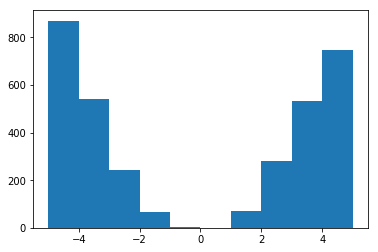

In [52]:
#histogram of all articles being shared
articles = []
for node in list(G.nodes):
    for article in node.articles:
        articles.append(article.sentiment) 

plt.hist(articles)

(array([473., 342., 152.,  51.,   3.,   0.,  56., 181., 335., 453.]),
 array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 <a list of 10 Patch objects>)

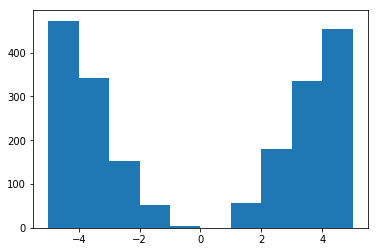

In [53]:
#histogram of UNIQUE articles being shared
articles_unique = []
articles_set = set()
for node in list(G.nodes):
    for article in node.articles:
        if article not in articles_set:
            articles_set.add(article)
            articles_unique.append(article.sentiment) 

plt.hist(articles_unique)

In [47]:
len(articles_unique)

20538

In [48]:
len(articles)

39136

(array([15.,  4., 17., 30., 29., 38., 23., 17.,  7., 20.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

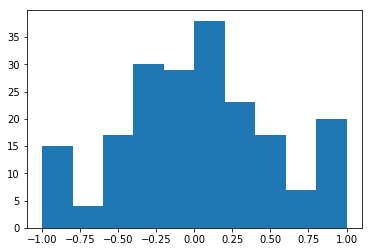

In [49]:
preferences = []
for node in users:
    preferences.append(node.preference)

plt.hist(preferences)